In [853]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.BaseModel()

In [854]:
z = pybamm.Variable("z") # state of charge
V = pybamm.Variable("V") # terminal voltage (V)
h = pybamm.Variable("h") # dynamic hysteresis voltage (V)
i_R1 = pybamm.Variable("i_R1") # resistor current (A)

Q = pybamm.Parameter("Q") # total charge capacity (C)
R_0 = pybamm.Parameter("R_0") # equivalent series resistance (Ohm)
R_1 = pybamm.Parameter("R_1") # equivalent series resistance (Ohm)
C_1 = pybamm.Parameter("C_1") # capactior (F)
gamma = pybamm.Parameter("gamma")

i = pybamm.FunctionParameter(
    "i", {"t": pybamm.t}
) # current (A)
M = pybamm.FunctionParameter(
    "M", {"i": i}
) # maximum polarisation due to hysteresis
eta = pybamm.FunctionParameter(
    "eta", {"i": i}
) # charge efficiency

In [855]:
ocv_data = pybamm.parameters.process_1D_data("ecm_example_ocv.csv")

def ocv(soc):
    name, (x, y) = ocv_data
    return pybamm.Interpolant(x, y, soc, name)

In [856]:
'''model.events += [
            pybamm.Event("Minimum SOC", z),
            pybamm.Event("Maximum SOC", 1 - z),
        ]'''

'model.events += [\n            pybamm.Event("Minimum SOC", z),\n            pybamm.Event("Maximum SOC", 1 - z),\n        ]'

In [857]:
dzdt = - eta * i / Q
di_R1dt = - i_R1 / (R_1 * C_1) - i / (R_1 * C_1)
V_gov = ocv(z) - i * R_0 - i_R1 * R_1 - V
# dhdt = - gamma * np.copysign(1,i) * (M(i) - h) * dzdt
dhdt = abs(eta * i * gamma / Q) * (M - h)

model.rhs = {z: dzdt, h: dhdt, i_R1: di_R1dt}
model.algebraic = {V: V_gov}

In [858]:
z0 = 1
h0 = -0.075
V0 = 0
i_R10 = 0
model.initial_conditions = {z: z0, h: h0, V: V0, i_R1: i_R10}
model.variables = {"z": z, "h": h, "V": V, "t": pybamm.t, "i": i}

In [859]:
def current_function(t):
    return 0.5 * (t < 20) - 0.5 * (t > 20) + 1 * (t > 40) - 1 * (t > 60) + 1 * (t > 80) - 1 * (t > 100)
    # return 0.5 * (t < 20) - 0.5 * (t > 20) + 0.5 * (t > 40) - 1 * (t > 60) + 1 * (t > 80) - 1 * (t > 100)

def eta_function(i):
    return 1 * (i >= 0) + 0.99 * (i < 0)
    
def M_function(i):
    return 0.1 * (i >= 0) - 0.1 * (i < 0)

In [860]:
parameter_values = pybamm.ParameterValues({"i": current_function, "M": M_function, "eta": current_function, 
                                           "Q": 5, "R_0": 0.0082, "R_1": 0.0158, "C_1": 38000, "gamma": 2})
parameter_values.process_model(model)

In [861]:
disc = pybamm.Discretisation()  # default discretisation
disc.process_model(model)

# solver = pybamm.ScipySolver()
solver = pybamm.CasadiSolver(mode="safe", atol=1e-5, rtol=1e-5)
t_span = np.linspace(0, 100, 100)
solution = solver.solve(model, t_span)

In [862]:
t_sol, z_sol = solution.t, solution.y  # get solution times and states
z = solution["z"]  # extract and process z, h and V from the solution
h = solution["h"]
V = solution["V"]

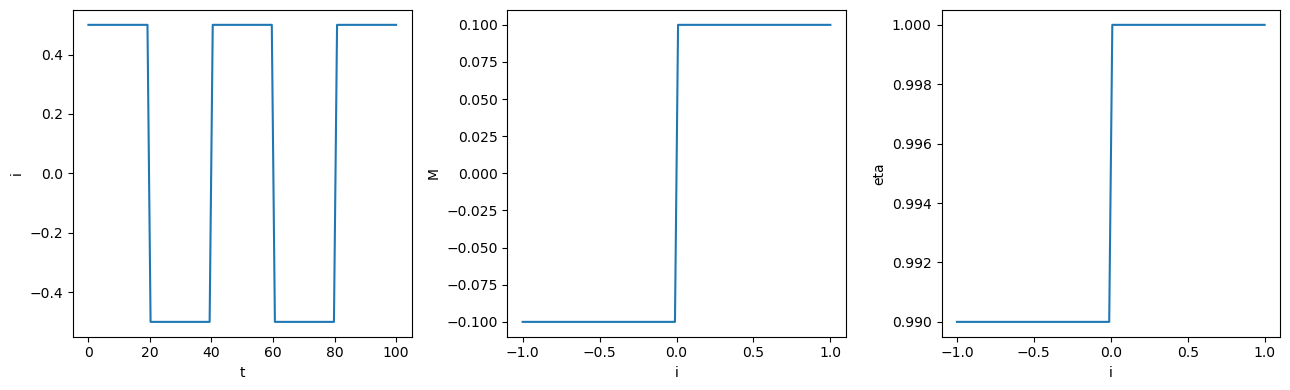

In [863]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))
x = np.linspace(-1,1,100)

ax1.plot(t_span, current_function(t_span))
ax1.set_xlabel("t")
ax1.set_ylabel("i")

ax2.plot(x, M_function(x))
ax2.set_xlabel("i")
ax2.set_ylabel("M")

ax3.plot(x, eta_function(x))
ax3.set_xlabel("i")
ax3.set_ylabel("eta")

plt.tight_layout()
plt.show()

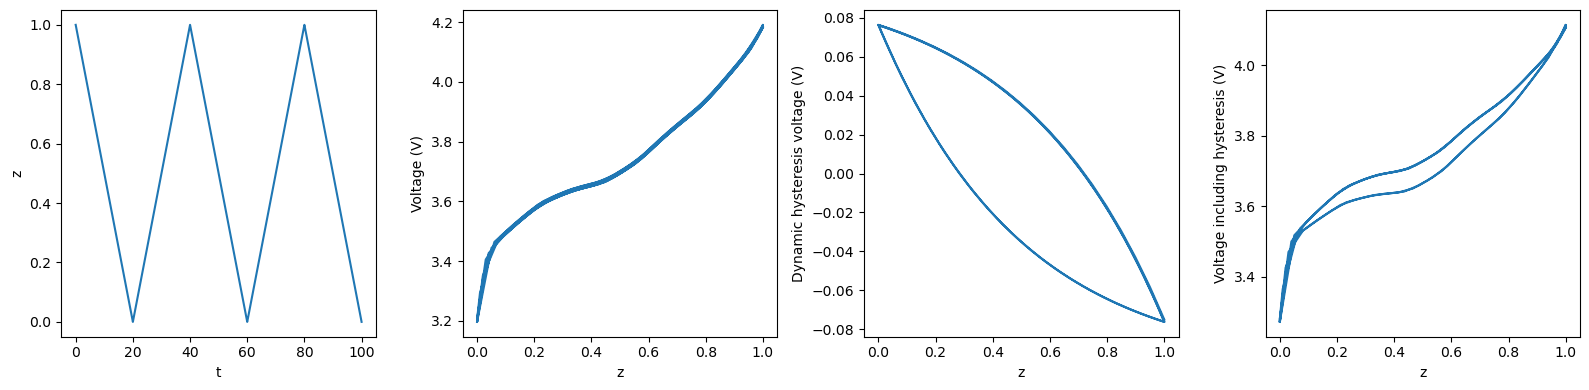

In [864]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))

ax1.plot(t_sol, z(t_sol))
ax1.set_xlabel("t")
ax1.set_ylabel("z")

ax2.plot(z(t_sol), V(t_sol))
ax2.set_xlabel("z")
ax2.set_ylabel("Voltage (V)")

ax3.plot(z(t_sol), h(t_sol))
ax3.set_xlabel("z")
ax3.set_ylabel("Dynamic hysteresis voltage (V)")

ax4.plot(z(t_sol), h(t_sol)+V(t_sol))
ax4.set_xlabel("z")
ax4.set_ylabel("Voltage including hysteresis (V)")

plt.tight_layout()
plt.show()